In [1]:
from collections import OrderedDict

import numpy as np
import nni
import torch

import nni.retiarii.nn.pytorch as nn
import pytorch_lightning as pl

from nni import trace
from nni.retiarii import model_wrapper, fixed_arch
from nni.retiarii.nn.pytorch import Cell
from nni.retiarii.experiment.pytorch import RetiariiExperiment, RetiariiExeConfig
from nni.retiarii.strategy import DARTS as DartsStrategy
from nni.retiarii.evaluator.pytorch import Lightning, LightningModule, Trainer
from nni.retiarii.evaluator.pytorch.lightning import DataLoader
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.utilities.types import STEP_OUTPUT

from torch import optim, tensor, zeros_like
from typing import Any

from darts.common_utils import *
from darts.early_stop import MSE
from darts.noises import add_selected_noise
from darts.phantom import generate_phantom

from torch.utils.data import Dataset

/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/lightning/fabric/__init__.py:29: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/pkg_resources/__init__.py:2350: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/

# space

In [2]:
def conv_2d(C_in, C_out, kernel_size=3, dilation=1, padding=1, activation=None):
    return nn.Sequential(
        nn.Conv2d(C_in, C_out, kernel_size=kernel_size, dilation=dilation, padding=padding, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU() if activation is None else activation,
        nn.Conv2d(C_out, C_out, kernel_size=kernel_size, dilation=dilation, padding=padding, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU() if activation is None else activation
    )

def depthwise_separable_conv(C_in, C_out, kernel_size=3, dilation=1, padding=1, activation=None):
    return nn.Sequential(
        nn.Conv2d(C_in, C_in, kernel_size=kernel_size, dilation=dilation, padding=padding, groups=C_in, bias=False),
        nn.Conv2d(C_in, C_out, 1, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU() if activation is None else activation,
        nn.Conv2d(C_out, C_out, kernel_size=kernel_size, dilation=dilation, padding=padding, groups=C_out, bias=False),
        nn.Conv2d(C_out, C_out, 1, bias=False),
        nn.BatchNorm2d(C_out),
        nn.ReLU() if activation is None else activation
    )

def pools():
    pool_dict = OrderedDict([
        ("MaxPool2d", nn.MaxPool2d(kernel_size=2, stride=2, padding=0)),
        # ("AvgPool2d", nn.AvgPool2d(kernel_size=2, stride=2, padding=0)),
        # ("DepthToSpace", nn.PixelShuffle(2)),
    ])
    return pool_dict

def upsamples():
    upsample_dict = OrderedDict([
        ("Upsample_nearest", nn.Upsample(scale_factor=2, mode='nearest')),
        ("Upsample_bilinear", nn.Upsample(scale_factor=2, mode='bilinear')),

    ])
    return upsample_dict

def convs(C_in, C_out):
    # all padding should follow this formula:
    # pd = (ks - 1) * dl // 2
    conv_dict = OrderedDict([
        
        ("conv2d_1x1_Relu", conv_2d(C_in, C_out)),
        # ("conv2d_1x1_SiLU", conv_2d(C_in, C_out, activation=nn.SiLU())),

        # # ("conv2d_3x3_Relu", conv_2d(C_in, C_out, kernel_size=3, padding=1)),
        ("conv2d_3x3_SiLU", conv_2d(C_in, C_out, kernel_size=3, padding=1, activation=nn.SiLU())),
        # ("conv2d_3x3_Relu_1dil", conv_2d(C_in, C_out, kernel_size=3, padding=2, dilation=2)),

        # # # ("conv2d_5x5_Relu", conv_2d(C_in, C_out, kernel_size=5, padding=2)),
        # ("conv2d_5x5_Relu_1dil", conv_2d(C_in, C_out, kernel_size=5, padding=4, dilation=2, activation=nn.SiLU())),
        # # ("conv2d_5x5_SiLU", conv_2d(C_in, C_out, kernel_size=5, padding=2, activation=nn.SiLU())),


        # ("convDS_1x1_Relu", depthwise_separable_conv(C_in, C_out)),
        # ("convDS_1x1_SiLU", depthwise_separable_conv(C_in, C_out, activation=nn.SiLU())),

        # ("convDS_3x3_Relu", depthwise_separable_conv(C_in, C_out, kernel_size=3, padding=1)),
        # # ("convDS_3x3_SiLU", depthwise_separable_conv(C_in, C_out, kernel_size=3, padding=1, activation=nn.SiLU())),

        # # ("convDS_5x5_Relu", depthwise_separable_conv(C_in, C_out, kernel_size=5, padding=2)),
        # ("convDS_5x5_SiLU", depthwise_separable_conv(C_in, C_out, kernel_size=5, padding=2, activation=nn.SiLU())),
    ])
    return conv_dict


class Preprocessor(nn.Module):
    def __init__(self, C_in, C_out):
        super().__init__()

        self.conv1 = nn.Conv2d(C_in, C_out, 1)

    def forward(self, x):
        return [self.conv1(x[0])]

class Postprocessor(nn.Module):
    def __init__(self, C_in, C_out):
        super().__init__()

        self.conv1 = nn.Conv2d(C_in, C_out, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C_in, C_out, kernel_size=3, padding=1)

    def forward(self, x):
        return [self.conv1(x[0]), self.conv2(x[1])]

@model_wrapper
class DARTS_UNet(nn.Module):
    def __init__(self, C_in=1, C_out=1, depth=4):
        super().__init__()

        # all padding should follow this formula:
        # pd = (ks - 1) * dl // 2
        self.pr = False
        self.depth = depth
        
        self.in_layer = nn.Conv2d(C_in, 64, kernel_size=3, padding=1)

        # Encoders
        filters = 64
        self.encoders = nn.ModuleList()
        for i in range(depth):
            self.encoders.append(Cell(pools(), num_nodes=1, num_ops_per_node=1, num_predecessors=1, label=f'pool_{i+1}'))
            self.encoders.append(Cell(convs(filters, filters*2), num_nodes=1, num_ops_per_node=1, num_predecessors=1, label=f'conv_{i+1}'))
            filters *= 2

        # Decoders
        self.decoders = nn.ModuleList()
        for i in range(depth):
            self.decoders.append(Cell(upsamples(), num_nodes=1, num_ops_per_node=1, num_predecessors=1, label=f'upsample_{i+1}'))
            filters //= 2
            self.decoders.append(Cell(convs(filters*3, filters), num_nodes=1, num_ops_per_node=1, num_predecessors=1, label=f'conv_{i+1+depth}'))

        self.out_layer = nn.Conv2d(64, C_out, kernel_size=3, padding=1)

    def forward(self, x):

        if self.pr:
            print(f'input shape: {x.shape}\n')

        x = self.in_layer(x)  # Apply the initial layer
        skip_connections = [x]

        for i in range(self.depth):
            x = self.encoders[2*i]([x])
            x = self.encoders[2*i+1]([x])
            skip_connections.append(x)

        for i in range(self.depth):
            upsampled = self.decoders[2*i]([x])
            cropped = self.crop_tensor(upsampled, skip_connections[-(i+2)])
            x = torch.cat([cropped, upsampled], 1)
            x = self.decoders[2*i+1]([x])

        x = self.out_layer(x)  # Apply the final layer

        return x

    def crop_tensor(self, target_tensor, tensor):
        target_size = target_tensor.size()[2]  # Assuming height and width are same
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2
        return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]
    
    def test(self):
        """
        This will input a random tensor of 1x1x128x128 and test the forward pass.
        """
        self.pr = True
        x = torch.randn(1, 1, 128, 128)
        y = self.forward(x)
        assert y.shape == (1, 1, 128, 128), "Output shape should be (1, 1, 128, 128), got {}".format(y.shape)
        print(f'output shape: {y.shape}\n')
        print("Test passed.\n\n")

model = DARTS_UNet(1, 1)
model.test()


input shape: torch.Size([1, 1, 128, 128])

output shape: torch.Size([1, 1, 128, 128])

Test passed.




/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/nni/nas/nn/pytorch/choice.py:274: UserWarning: You should not run forward of this module directly.
  warnings.warn('You should not run forward of this module directly.')
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/nni/nas/nn/pytorch/choice.py:186: UserWarning: You should not run forward of this module directly.
  warnings.warn('You should not run forward of this module directly.')


# LR scheduler

In [3]:
class SingleImageDataset(Dataset):
    def __init__(self, image, num_iter):
        self.image = image
        self.num_iter = num_iter

    def __len__(self):
        return self.num_iter

    def __getitem__(self, index):
        # Always return the same image (and maybe a noise tensor or other information if necessary??)
        return self.image

@trace
class LightningEvalSearch(LightningModule):
    def __init__(self, phantom=None, buffer_size=100, num_iter=1,
                lr=0.01, noise_type='gaussian', noise_factor=0.15, resolution=6, 
                n_channels=1, reg_noise_std_val=1./30.,
                buffer_no_lr_schuler=700, patience=100,
                ):
        super().__init__()

        # input
        self.phantom = phantom

        # Loss
        # self.criterion = nn.MSELoss().to(self.device)
        self.criterion = nn.BCEWithLogitsLoss().to(self.device)
        
        # Hyperparameters / Inputs
        self.buffer_size = buffer_size
        self.num_iter = num_iter
        self.lr = lr
        self.noise_type = noise_type
        self.noise_factor = noise_factor
        self.resolution = resolution
        self.n_channels = n_channels
        self.reg_noise_std = tensor(reg_noise_std_val)

        self.buffer_no_lr_schuler = buffer_no_lr_schuler
        self.patience = patience

        # adjusting input
        if self.phantom is None:
            self.img_np, _, _, self.img_noisy_torch = self.preprocess_image(self.resolution, self.noise_type, self.noise_factor)
        else:
            self.img_np, _, _, self.img_noisy_torch = self.preprocess_image(self.resolution, self.noise_type, self.noise_factor, input_img_np=self.phantom)
        self.net_input = get_noise(input_depth=1, spatial_size=self.img_np.shape[1], noise_type=self.noise_type)
        
        # History and early stopper
        self.loss_history = []
        self.variance_history = []
        self.img_collection = []
        
    def forward(self, net_input):
        net_input_perturbed = net_input + zeros_like(net_input).normal_(std=self.reg_noise_std)
        return self.model(net_input_perturbed)
    
    def training_step(self, batch, batch_idx):
        """
        Deep Image Prior

        training here follows closely from the following two repos: 
            - the deep image prior repo
            - a DIP early stopping repo (Lighting has early stopping functionality so this blends the two)
        """        
        self.counter += 1

        r_img_torch = self.forward(self.net_input)
        r_img_np = torch_to_np(r_img_torch)

        # update loss and loss history
        total_loss = self.criterion(r_img_torch, self.img_noisy_torch)
        self.latest_loss = total_loss.item()
        self.loss_history.append(total_loss.item())
        # self.logger.log_metrics({'loss': total_loss.item()})

        # update img collection
        r_img_np = r_img_np.reshape(-1)
        self.update_img_collection(r_img_np)
        img_collection = self.get_img_collection()

        # if len(img_collection) == self.buffer_size:
        if len(img_collection) >= self.buffer_size // 2:

            # update variance and var history
            ave_img = np.mean(img_collection, axis=0)
            variance = [MSE(ave_img, tmp) for tmp in img_collection]
            self.cur_var = np.mean(variance)
            self.variance_history.append(self.cur_var)

            # update log
            #self.latest_loss = total_loss.item()
            self.log('variance', self.cur_var)
            self.log('loss', self.latest_loss)

            # Using global_step to count iterations
            if self.counter % 10 == 0:
                nni.report_intermediate_result({'Iteration':self.counter,'variance':self.cur_var, 'loss': self.latest_loss})
        else:
            #self.latest_loss = total_loss.item()
            self.log('loss', self.latest_loss)
            # log a fake variance to fool the early stopper and lr scheduler
            self.log('variance', 1-self.counter/1000000)
            if self.counter % 10 == 0:
                nni.report_intermediate_result({'Iteration':self.counter,'variance': "iterations <= buffer_size // 2", 'loss': total_loss.item()})
        
        if self.counter % 100 == 0:
            self.plot_progress()

        return {"loss": total_loss}
    
    def validation_step(self, batch, batch_idx):
        # your validation logic here
        return {'loss': self.latest_loss, 'variance': self.cur_var} if self.counter >= self.buffer_size else {'loss': self.latest_loss, 'variance': 1-self.counter/1000000}


    def configure_optimizers(self):
        """
        Basic Adam Optimizer
        LR Scheduler: ReduceLROnPlateau
        1 Parameter Group
        """
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        # self.buffer_no_lr_schuler = 700

        self.monitor = 'variance'
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=self.patience, verbose=True)
    
        # Reduce learning rate when a metric has stopped improving
        # Here 'min' means that the metric should decrease for the lr to be reduced
        scheduler = {
            'scheduler': self.scheduler,
            'monitor': self.monitor, # probably want this to be variance eventually
            'interval': 'step',
            'strict': True,
            'frequency': 1,
        }
        
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}
        # return optimizer
        
    def lr_scheduler_step(self, *args, **kwargs):
        # needed to modify
        # one-shot methods interfere with this for some reason
        

        scheduler = kwargs.get('scheduler', args[0] if args else None)
        metric = kwargs.get('metric', args[1] if len(args) > 1 else None)
        metric = self.trainer.logged_metrics[self.monitor]

        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau) and metric is not None:
            if self.counter >= self.buffer_no_lr_schuler:
                scheduler.step(metric) # self.cur_var
        else:
            scheduler.step()
    
    def optimizer_zero_grad(self, epoch, batch_idx, optimizer, opt_idx):
        # Not sure if this is the default logic in the nni.retiarii.evaluator.pytorch.LightningModule
        # needed to modify so it can accept the opt_idx argument
        optimizer.zero_grad()
    
    def configure_gradient_clipping(self, optimizer, opt_idx, gradient_clip_val, gradient_clip_algorithm):
        # Not sure if this is the default logic in the nni.retiarii.evaluator.pytorch.LightningModule
        # needed to modify so it can accept the opt_idx argument
        # now need to define the clipping logic
        self.clip_gradients(
            optimizer,
            gradient_clip_val=gradient_clip_val,
            gradient_clip_algorithm=gradient_clip_algorithm
        )

    def set_model(self, model):
        # This will be called after __init__ and will set the candidate model
        # needed for NAS but not for a standard training loop
        self.model = model
    
    def train_dataloader(self):
        """
        Dummy DataLoader that returns nothing but makes PyTorch Lightning's training loop work
        """
        dataset = SingleImageDataset(self.phantom, self.num_iter)
        return DataLoader(dataset, batch_size=1)
    
    def on_train_start(self):
        """
        Move all tensors to the GPU to begin training
        """
        self.model.to(self.device)
        self.net_input = self.net_input.to(self.device)
        self.img_noisy_torch = self.img_noisy_torch.to(self.device)
        self.reg_noise_std = self.reg_noise_std.to(self.device)
        self.counter = 0

    def on_train_end(self, **kwargs: Any):
        """
        Report final metrics and display the results
        """
        # final log


        # # plot images to see results
        self.plot_progress()


    # def test_step(self, *args: Any, **kwargs: Any) -> STEP_OUTPUT | None:
    #     pass

    def val_dataloader(self):
        """
        Dummy DataLoader for validation.
        """
        dataset = SingleImageDataset(self.phantom, self.num_iter)
        return DataLoader(dataset, batch_size=1)
    
    # def validation_step(self, trainer, *args: Any, **kwargs: Any) -> STEP_OUTPUT | None:
    #     # if self.buffer_size == len(self.img_collection):
    #     #     self._run_early_stopping_check(trainer)
    #     pass

    def update_img_collection(self, cur_img):
        self.img_collection.append(cur_img)
        if len(self.img_collection) > self.buffer_size:
            self.img_collection.pop(0)

    def get_img_collection(self):
        return self.img_collection

    def preprocess_image(self, resolution, noise_type, noise_factor, input_img_np=None):
        """
        Generates an image (or takes an input phantom), adds noise, and converts it to both numpy and torch tensors.

        Args:
        - resolution (int): Resolution for the phantom image.
        - noise_type (str): Type of noise to add.
        - noise_factor (float): Noise factor.
        - input_img_np (numpy.ndarray, optional): Input raw image in numpy format. If not provided, a new image will be generated.

        Returns:
        - img_np (numpy.ndarray): Original image in numpy format.
        - img_noisy_np (numpy.ndarray): Noisy image in numpy format.
        - img_torch (torch.Tensor): Original image in torch tensor format.
        - img_noisy_torch (torch.Tensor): Noisy image in torch tensor format.
        """
        if input_img_np is None:
            raw_img_np = generate_phantom(resolution=resolution) # 1x64x64 np array
        else:
            raw_img_np = input_img_np.copy() # 1x64x64 np array
            
        img_np = raw_img_np.copy() # 1x64x64 np array
        img_torch = torch.tensor(raw_img_np, dtype=torch.float32).unsqueeze(0) # 1x1x64x64 torch tensor
        img_noisy_torch = add_selected_noise(img_torch, noise_type=noise_type, noise_factor=noise_factor) # 1x1x64x64 torch tensor
        img_noisy_np = img_noisy_torch.squeeze(0).numpy() # 1x64x64 np array
        
        return img_np, img_noisy_np, img_torch, img_noisy_torch
    
    def plot_progress(self):
        denoised_img = self.forward(self.net_input).detach().cpu().squeeze().numpy()
        
        _, ax = plt.subplots(1, 3, figsize=(10, 5))

        ax[0].imshow(self.img_np.squeeze(), cmap='gray')
        ax[0].set_title("Original Image")
        ax[0].axis('off')

        ax[1].imshow(denoised_img, cmap='gray')
        ax[1].set_title("Denoised Image")
        ax[1].axis('off')

        ax[2].imshow(self.img_noisy_torch.detach().cpu().squeeze().numpy(), cmap='gray')
        ax[2].set_title("Noisy Image")
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()


class _EarlyStopping(EarlyStopping, pl.Callback):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        
# input image (phantom)
resolution = 7
phantom = generate_phantom(resolution=resolution)

# early stopper
early_stop_callback = _EarlyStopping(
                        monitor="variance", 
                        mode="min", 
                        patience=6, 
                        verbose=True,
                        min_delta=0
                        )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:327: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor', 'interval', 'strict', 'frequency'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  rank_zero_warn(

  | Name  | Type                | Params
----------------------------------------------
0 | model | LightningEvalSearch | 62.7 M
----------------------------------------------
62.7 M    Trainable params
0         Non-trainable params
62.7 M    Total params
250.772   Total estimated model params size (MB)
/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240:

Training: 0it [00:00, ?it/s]

/home/joe/.cache/pypoetry/virtualenvs/nas-test-OHy8kATa-py3.8/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


[2023-08-25 20:06:57] Intermediate result: {"Iteration": 10, "variance": "iterations <= buffer_size // 2", "loss": 0.4309965968132019}  (Index 0)
[2023-08-25 20:06:58] Intermediate result: {"Iteration": 20, "variance": "iterations <= buffer_size // 2", "loss": 0.40398073196411133}  (Index 1)
[2023-08-25 20:06:59] Intermediate result: {"Iteration": 30, "variance": "iterations <= buffer_size // 2", "loss": 0.36925041675567627}  (Index 2)
[2023-08-25 20:07:00] Intermediate result: {"Iteration": 40, "variance": "iterations <= buffer_size // 2", "loss": 0.35383865237236023}  (Index 3)
[2023-08-25 20:07:01] Intermediate result: {"Iteration": 50, "variance": 23.027377905845643, "loss": 0.34211504459381104}  (Index 4)
[2023-08-25 20:07:02] Intermediate result: {"Iteration": 60, "variance": 22.39455402692159, "loss": 0.334952712059021}  (Index 5)
[2023-08-25 20:07:03] Intermediate result: {"Iteration": 70, "variance": 22.351224521228247, "loss": 0.3286690413951874}  (Index 6)
[2023-08-25 20:07:

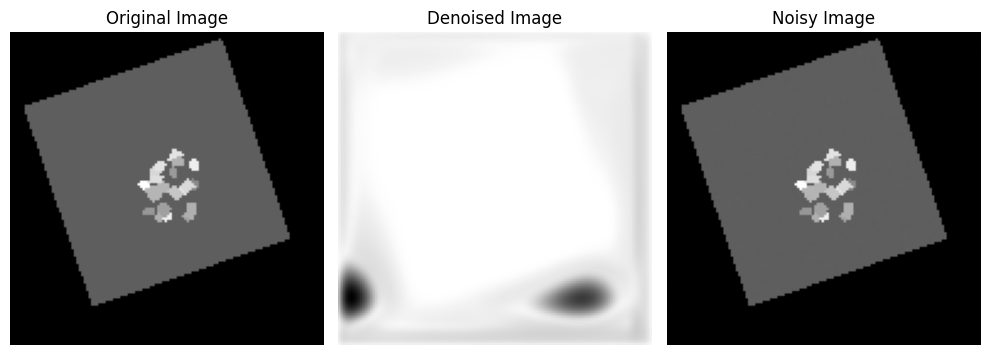

[2023-08-25 20:07:07] Intermediate result: {"Iteration": 110, "variance": 17.750464606285096, "loss": 0.31451767683029175}  (Index 10)
[2023-08-25 20:07:08] Intermediate result: {"Iteration": 120, "variance": 16.34885171175003, "loss": 0.3130210041999817}  (Index 11)
[2023-08-25 20:07:09] Intermediate result: {"Iteration": 130, "variance": 14.764208447933196, "loss": 0.31193307042121887}  (Index 12)
[2023-08-25 20:07:10] Intermediate result: {"Iteration": 140, "variance": 12.44213915348053, "loss": 0.311367928981781}  (Index 13)
[2023-08-25 20:07:11] Intermediate result: {"Iteration": 150, "variance": 9.22663152217865, "loss": 0.3123536705970764}  (Index 14)
[2023-08-25 20:07:12] Intermediate result: {"Iteration": 160, "variance": 5.41431898355484, "loss": 0.3112003207206726}  (Index 15)
[2023-08-25 20:07:13] Intermediate result: {"Iteration": 170, "variance": 3.139217787384987, "loss": 0.31081849336624146}  (Index 16)
[2023-08-25 20:07:14] Intermediate result: {"Iteration": 180, "vari

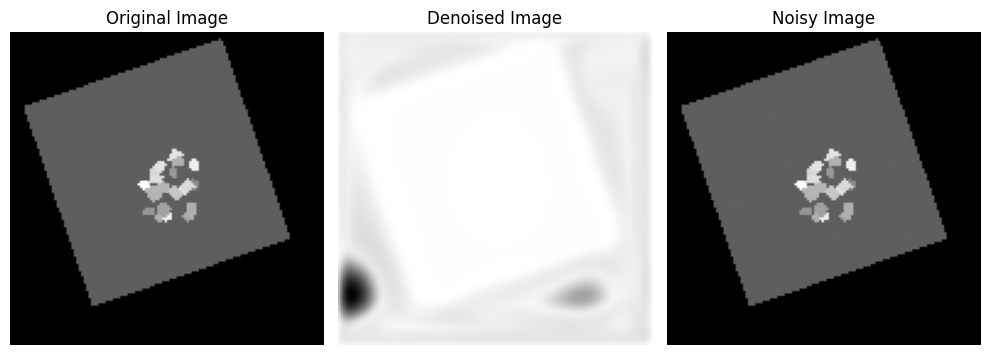

[2023-08-25 20:07:18] Intermediate result: {"Iteration": 210, "variance": 4.036349754035473, "loss": 0.30826854705810547}  (Index 20)
[2023-08-25 20:07:19] Intermediate result: {"Iteration": 220, "variance": 4.5784789611399175, "loss": 0.3079237937927246}  (Index 21)
[2023-08-25 20:07:20] Intermediate result: {"Iteration": 230, "variance": 4.861510478407144, "loss": 0.3076397776603699}  (Index 22)
[2023-08-25 20:07:21] Intermediate result: {"Iteration": 240, "variance": 4.794665356129408, "loss": 0.3073384463787079}  (Index 23)
[2023-08-25 20:07:22] Intermediate result: {"Iteration": 250, "variance": 4.21329047948122, "loss": 0.3071712851524353}  (Index 24)
[2023-08-25 20:07:23] Intermediate result: {"Iteration": 260, "variance": 3.3601951931416987, "loss": 0.30680882930755615}  (Index 25)
[2023-08-25 20:07:24] Intermediate result: {"Iteration": 270, "variance": 2.512222036123276, "loss": 0.3066138029098511}  (Index 26)
[2023-08-25 20:07:25] Intermediate result: {"Iteration": 280, "var

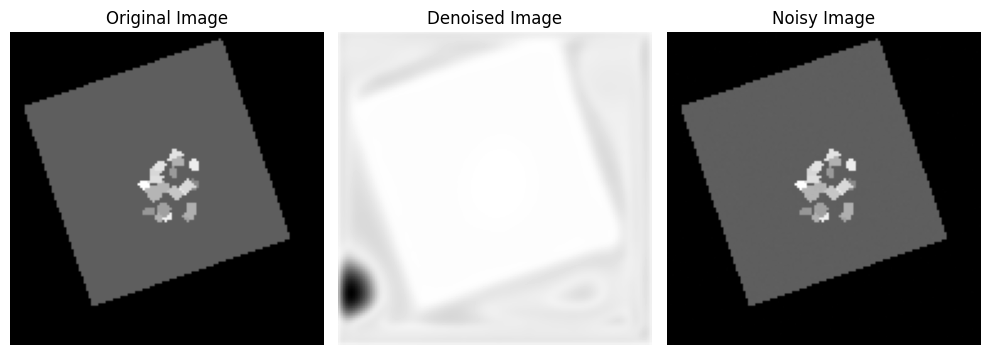

[2023-08-25 20:07:28] Intermediate result: {"Iteration": 310, "variance": 0.659036733172834, "loss": 0.3081739544868469}  (Index 30)
[2023-08-25 20:07:29] Intermediate result: {"Iteration": 320, "variance": 0.5769730617851019, "loss": 0.307293176651001}  (Index 31)
[2023-08-25 20:07:30] Intermediate result: {"Iteration": 330, "variance": 0.5570576099306345, "loss": 0.3064168095588684}  (Index 32)
[2023-08-25 20:07:31] Intermediate result: {"Iteration": 340, "variance": 0.5567718053609133, "loss": 0.3061576783657074}  (Index 33)
[2023-08-25 20:07:32] Intermediate result: {"Iteration": 350, "variance": 0.5485382567346097, "loss": 0.3058620095252991}  (Index 34)
[2023-08-25 20:07:33] Intermediate result: {"Iteration": 360, "variance": 0.5413369047641754, "loss": 0.30563634634017944}  (Index 35)
[2023-08-25 20:07:34] Intermediate result: {"Iteration": 370, "variance": 0.5478740405291319, "loss": 0.305380254983902}  (Index 36)
[2023-08-25 20:07:35] Intermediate result: {"Iteration": 380, "v

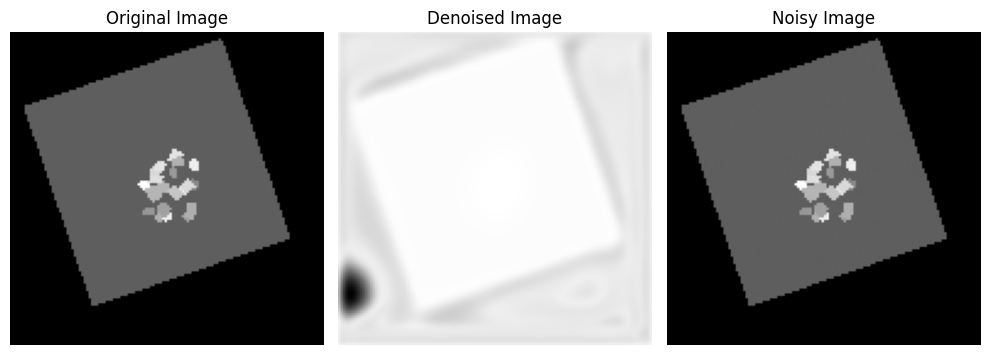

[2023-08-25 20:07:38] Intermediate result: {"Iteration": 410, "variance": 0.5144980321079493, "loss": 0.30672770738601685}  (Index 40)
[2023-08-25 20:07:39] Intermediate result: {"Iteration": 420, "variance": 0.47483458649367094, "loss": 0.306143581867218}  (Index 41)
[2023-08-25 20:07:40] Intermediate result: {"Iteration": 430, "variance": 0.46040655598044394, "loss": 0.30549687147140503}  (Index 42)
[2023-08-25 20:07:41] Intermediate result: {"Iteration": 440, "variance": 0.47067132622003555, "loss": 0.30517321825027466}  (Index 43)
[2023-08-25 20:07:42] Intermediate result: {"Iteration": 450, "variance": 0.47256791532039644, "loss": 0.3048222064971924}  (Index 44)
[2023-08-25 20:07:43] Intermediate result: {"Iteration": 460, "variance": 0.48084878385066987, "loss": 0.30470848083496094}  (Index 45)
[2023-08-25 20:07:44] Intermediate result: {"Iteration": 470, "variance": 0.503310808762908, "loss": 0.30458617210388184}  (Index 46)
[2023-08-25 20:07:45] Intermediate result: {"Iteration

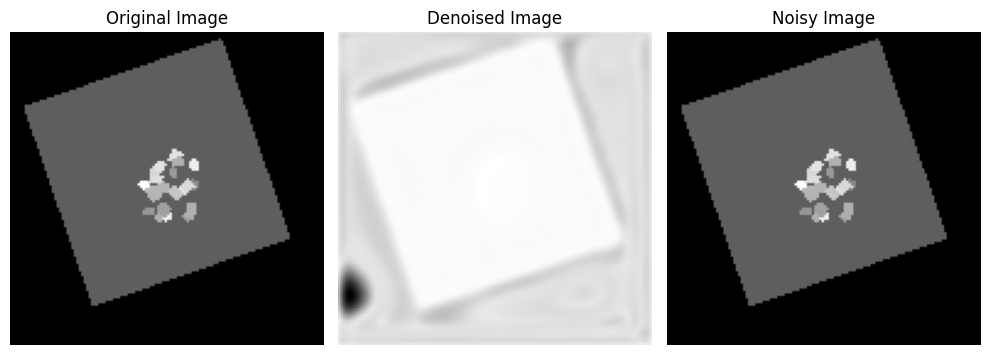

[2023-08-25 20:07:49] Intermediate result: {"Iteration": 510, "variance": 0.48973152227699757, "loss": 0.3042910397052765}  (Index 50)
[2023-08-25 20:07:50] Intermediate result: {"Iteration": 520, "variance": 0.4175466609746218, "loss": 0.30413031578063965}  (Index 51)
[2023-08-25 20:07:51] Intermediate result: {"Iteration": 530, "variance": 0.37800747266039253, "loss": 0.3041263222694397}  (Index 52)
[2023-08-25 20:07:52] Intermediate result: {"Iteration": 540, "variance": 0.3521786793321371, "loss": 0.30392587184906006}  (Index 53)
[2023-08-25 20:07:53] Intermediate result: {"Iteration": 550, "variance": 0.3270112183690071, "loss": 0.30390387773513794}  (Index 54)
[2023-08-25 20:07:54] Intermediate result: {"Iteration": 560, "variance": 0.31281325783580544, "loss": 0.3040742874145508}  (Index 55)
[2023-08-25 20:07:55] Intermediate result: {"Iteration": 570, "variance": 0.3022906596027315, "loss": 0.3037008047103882}  (Index 56)
[2023-08-25 20:07:56] Intermediate result: {"Iteration":

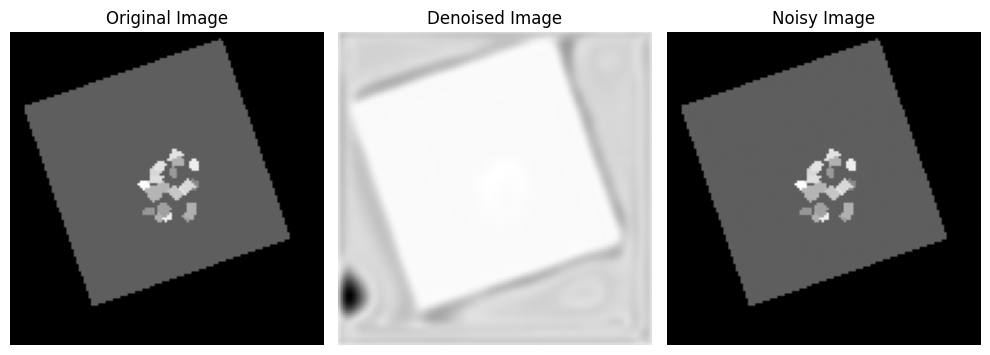

[2023-08-25 20:07:59] Intermediate result: {"Iteration": 610, "variance": 0.24695630859583617, "loss": 0.30527323484420776}  (Index 60)
[2023-08-25 20:08:00] Intermediate result: {"Iteration": 620, "variance": 0.2531907697767019, "loss": 0.30651381611824036}  (Index 61)
[2023-08-25 20:08:01] Intermediate result: {"Iteration": 630, "variance": 0.26472446784377096, "loss": 0.3055148720741272}  (Index 62)
[2023-08-25 20:08:02] Intermediate result: {"Iteration": 640, "variance": 0.273264933899045, "loss": 0.30517804622650146}  (Index 63)
[2023-08-25 20:08:03] Intermediate result: {"Iteration": 650, "variance": 0.2680955774337053, "loss": 0.3044757544994354}  (Index 64)
[2023-08-25 20:08:04] Intermediate result: {"Iteration": 660, "variance": 0.258419943228364, "loss": 0.30415841937065125}  (Index 65)
[2023-08-25 20:08:05] Intermediate result: {"Iteration": 670, "variance": 0.25808975026011466, "loss": 0.3039240837097168}  (Index 66)
[2023-08-25 20:08:06] Intermediate result: {"Iteration": 

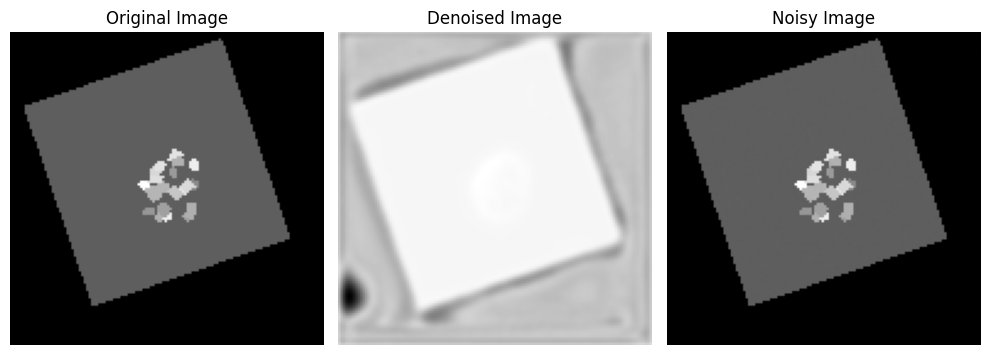

[2023-08-25 20:08:10] Intermediate result: {"Iteration": 710, "variance": 0.2621602936834097, "loss": 0.30352380871772766}  (Index 70)
[2023-08-25 20:08:11] Intermediate result: {"Iteration": 720, "variance": 0.23289425760507584, "loss": 0.30349665880203247}  (Index 71)
[2023-08-25 20:08:12] Intermediate result: {"Iteration": 730, "variance": 0.19566181782633066, "loss": 0.30342504382133484}  (Index 72)
[2023-08-25 20:08:13] Intermediate result: {"Iteration": 740, "variance": 0.1640176120772958, "loss": 0.30310752987861633}  (Index 73)
[2023-08-25 20:08:14] Intermediate result: {"Iteration": 750, "variance": 0.13289130061864854, "loss": 0.3030018210411072}  (Index 74)
[2023-08-25 20:08:15] Intermediate result: {"Iteration": 760, "variance": 0.11216498095542192, "loss": 0.3033706247806549}  (Index 75)
[2023-08-25 20:08:16] Intermediate result: {"Iteration": 770, "variance": 0.10264869749546052, "loss": 0.30289316177368164}  (Index 76)
[2023-08-25 20:08:17] Intermediate result: {"Iterati

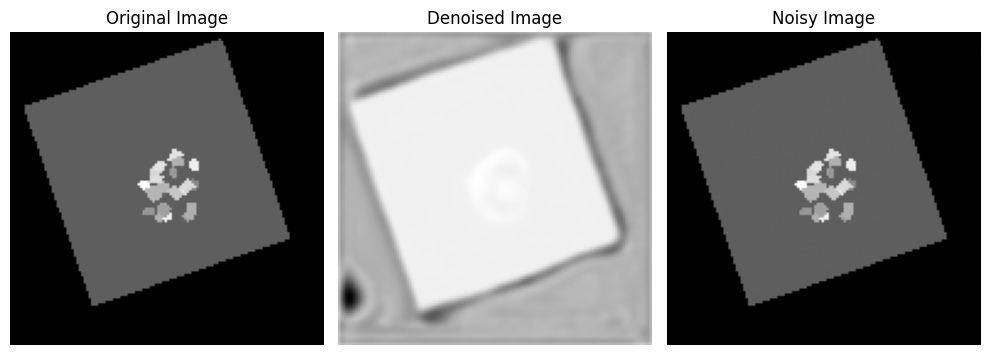

[2023-08-25 20:08:20] Intermediate result: {"Iteration": 810, "variance": 0.25190719433128833, "loss": 0.3072441816329956}  (Index 80)
[2023-08-25 20:08:21] Intermediate result: {"Iteration": 820, "variance": 0.29520477157086134, "loss": 0.30609065294265747}  (Index 81)
[2023-08-25 20:08:22] Intermediate result: {"Iteration": 830, "variance": 0.33310197792947294, "loss": 0.3049692213535309}  (Index 82)
[2023-08-25 20:08:23] Intermediate result: {"Iteration": 840, "variance": 0.34545349821448323, "loss": 0.30400019884109497}  (Index 83)
[2023-08-25 20:08:24] Intermediate result: {"Iteration": 850, "variance": 0.3465053650736809, "loss": 0.3036316931247711}  (Index 84)
[2023-08-25 20:08:25] Intermediate result: {"Iteration": 860, "variance": 0.33700531713664533, "loss": 0.3034324645996094}  (Index 85)
[2023-08-25 20:08:26] Intermediate result: {"Iteration": 870, "variance": 0.3356169471144676, "loss": 0.30315306782722473}  (Index 86)
[2023-08-25 20:08:27] Intermediate result: {"Iteration

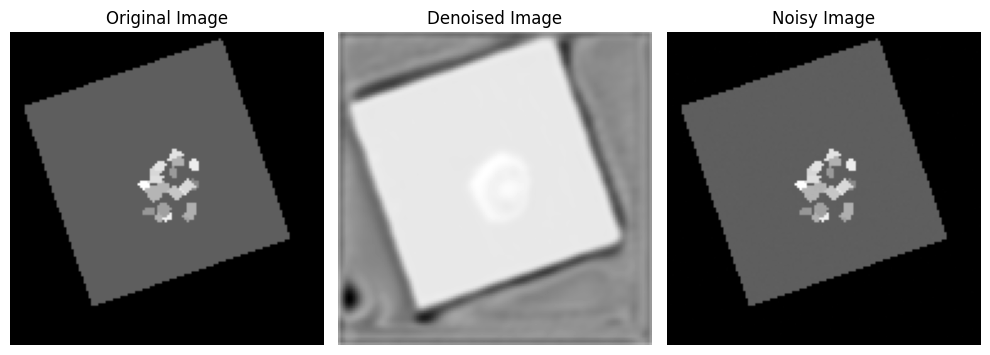

[2023-08-25 20:08:30] Intermediate result: {"Iteration": 910, "variance": 0.21453385159373284, "loss": 0.3029826283454895}  (Index 90)
[2023-08-25 20:08:31] Intermediate result: {"Iteration": 920, "variance": 0.1842177091538906, "loss": 0.30241769552230835}  (Index 91)
[2023-08-25 20:08:32] Intermediate result: {"Iteration": 930, "variance": 0.140745486728847, "loss": 0.30269655585289}  (Index 92)
[2023-08-25 20:08:33] Intermediate result: {"Iteration": 940, "variance": 0.11286846715956926, "loss": 0.30244338512420654}  (Index 93)
[2023-08-25 20:08:34] Intermediate result: {"Iteration": 950, "variance": 0.09908658862113953, "loss": 0.302298903465271}  (Index 94)
[2023-08-25 20:08:35] Intermediate result: {"Iteration": 960, "variance": 0.08391692264005542, "loss": 0.3021935224533081}  (Index 95)
[2023-08-25 20:08:36] Intermediate result: {"Iteration": 970, "variance": 0.07537352837622166, "loss": 0.3022592067718506}  (Index 96)
[2023-08-25 20:08:37] Intermediate result: {"Iteration": 98

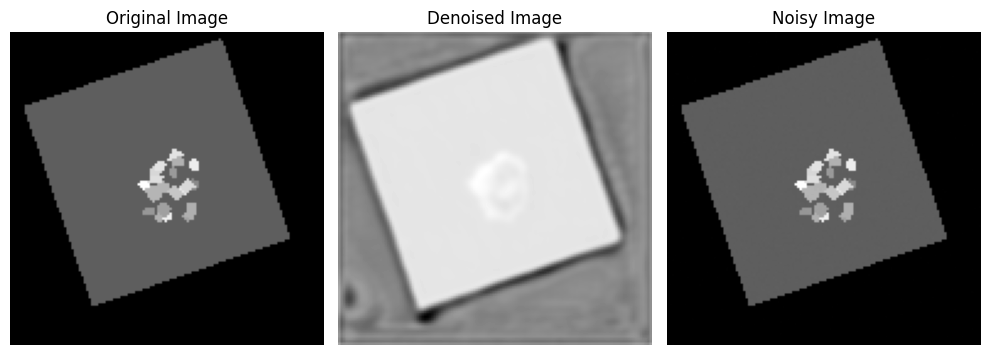

[2023-08-25 20:08:41] Intermediate result: {"Iteration": 1010, "variance": 0.05857480281963944, "loss": 0.30227887630462646}  (Index 100)
[2023-08-25 20:08:42] Intermediate result: {"Iteration": 1020, "variance": 0.0626709446310997, "loss": 0.3021000623703003}  (Index 101)
[2023-08-25 20:08:43] Intermediate result: {"Iteration": 1030, "variance": 0.07049138829112053, "loss": 0.30316466093063354}  (Index 102)
[2023-08-25 20:08:44] Intermediate result: {"Iteration": 1040, "variance": 0.0717399855144322, "loss": 0.3019694685935974}  (Index 103)
[2023-08-25 20:08:45] Intermediate result: {"Iteration": 1050, "variance": 0.07408848868682981, "loss": 0.3019935190677643}  (Index 104)
[2023-08-25 20:08:46] Intermediate result: {"Iteration": 1060, "variance": 0.07577924124896526, "loss": 0.3019510507583618}  (Index 105)
[2023-08-25 20:08:47] Intermediate result: {"Iteration": 1070, "variance": 0.0821656446158886, "loss": 0.30197691917419434}  (Index 106)
[2023-08-25 20:08:48] Intermediate result

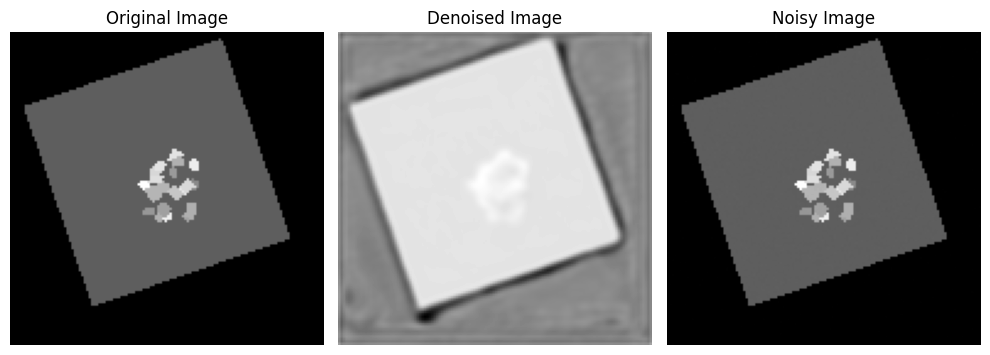

[2023-08-25 20:08:51] Intermediate result: {"Iteration": 1110, "variance": 0.09315543044358492, "loss": 0.30189788341522217}  (Index 110)
[2023-08-25 20:08:52] Intermediate result: {"Iteration": 1120, "variance": 0.08737578377127647, "loss": 0.3018229007720947}  (Index 111)
[2023-08-25 20:08:53] Intermediate result: {"Iteration": 1130, "variance": 0.08534024856984615, "loss": 0.30213263630867004}  (Index 112)
[2023-08-25 20:08:54] Intermediate result: {"Iteration": 1140, "variance": 0.0852522823959589, "loss": 0.3021109402179718}  (Index 113)
[2023-08-25 20:08:55] Intermediate result: {"Iteration": 1150, "variance": 0.08432219214737416, "loss": 0.30169790983200073}  (Index 114)
[2023-08-25 20:08:56] Intermediate result: {"Iteration": 1160, "variance": 0.08733921743929386, "loss": 0.30174535512924194}  (Index 115)
[2023-08-25 20:08:57] Intermediate result: {"Iteration": 1170, "variance": 0.08403653226792812, "loss": 0.3016904294490814}  (Index 116)
[2023-08-25 20:08:58] Intermediate res

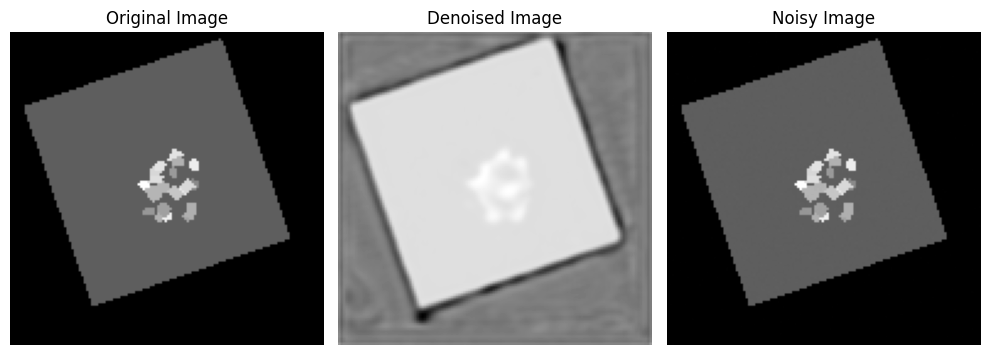

[2023-08-25 20:09:01] Intermediate result: {"Iteration": 1210, "variance": 0.07119072962552309, "loss": 0.3011093735694885}  (Index 120)
[2023-08-25 20:09:02] Intermediate result: {"Iteration": 1220, "variance": 0.07089573496952653, "loss": 0.3014282286167145}  (Index 121)
[2023-08-25 20:09:03] Intermediate result: {"Iteration": 1230, "variance": 0.06830036513507366, "loss": 0.30125176906585693}  (Index 122)
[2023-08-25 20:09:04] Intermediate result: {"Iteration": 1240, "variance": 0.06388854403048753, "loss": 0.3009469509124756}  (Index 123)
[2023-08-25 20:09:05] Intermediate result: {"Iteration": 1250, "variance": 0.06260081555694341, "loss": 0.301079124212265}  (Index 124)
[2023-08-25 20:09:06] Intermediate result: {"Iteration": 1260, "variance": 0.0611984234303236, "loss": 0.3008921146392822}  (Index 125)
[2023-08-25 20:09:07] Intermediate result: {"Iteration": 1270, "variance": 0.06116599217057228, "loss": 0.3008306622505188}  (Index 126)
[2023-08-25 20:09:08] Intermediate result:

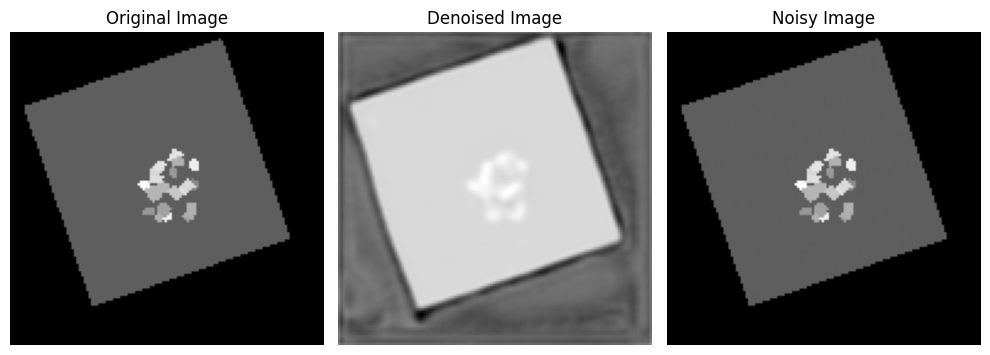

[2023-08-25 20:09:12] Intermediate result: {"Iteration": 1310, "variance": 0.12175104178488255, "loss": 0.30227410793304443}  (Index 130)
[2023-08-25 20:09:13] Intermediate result: {"Iteration": 1320, "variance": 0.13615683812648058, "loss": 0.3015456795692444}  (Index 131)
[2023-08-25 20:09:14] Intermediate result: {"Iteration": 1330, "variance": 0.14110276900231838, "loss": 0.30099397897720337}  (Index 132)
[2023-08-25 20:09:15] Intermediate result: {"Iteration": 1340, "variance": 0.1443842737004161, "loss": 0.30087727308273315}  (Index 133)
[2023-08-25 20:09:16] Intermediate result: {"Iteration": 1350, "variance": 0.14525123372673987, "loss": 0.3008592128753662}  (Index 134)
[2023-08-25 20:09:17] Intermediate result: {"Iteration": 1360, "variance": 0.1455557806789875, "loss": 0.3007751703262329}  (Index 135)
[2023-08-25 20:09:18] Intermediate result: {"Iteration": 1370, "variance": 0.14620061561465264, "loss": 0.3004716634750366}  (Index 136)
[2023-08-25 20:09:19] Intermediate resul

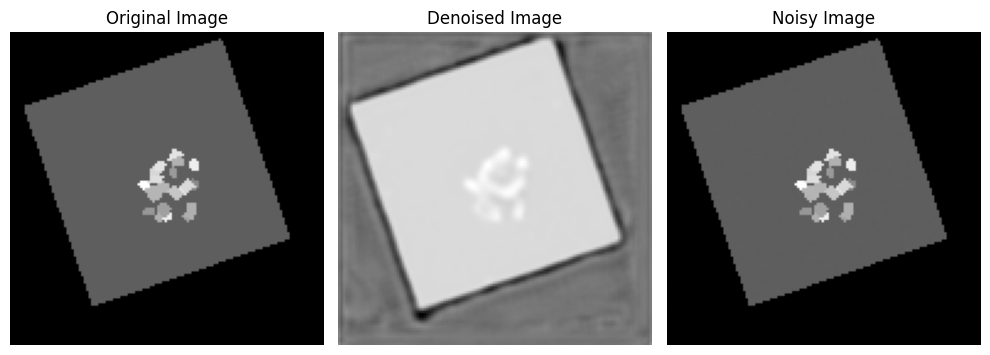

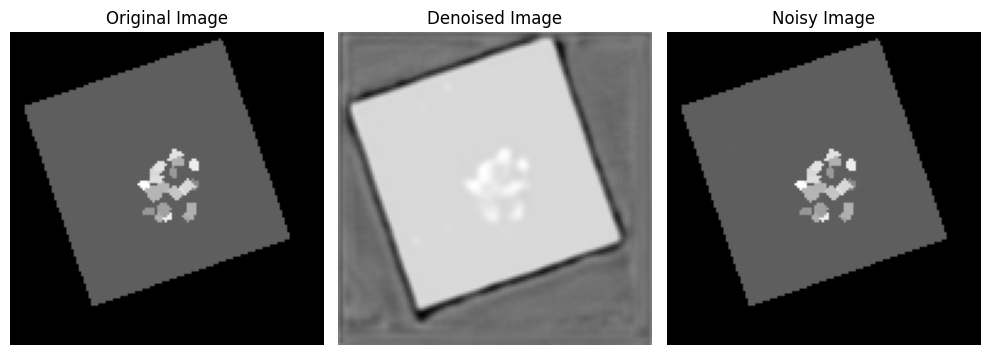

In [4]:

num_iter = 1
total_iterations = 1400

# Create the lightning module
module = LightningEvalSearch(
                phantom=phantom, 
                buffer_size=100,
                num_iter=num_iter,
                lr=0.01, 
                noise_type='gaussian', 
                noise_factor=0.002, 
                resolution=resolution,
                buffer_no_lr_schuler=600,
                patience=200,
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            # callbacks=[early_stop_callback],
            max_epochs=total_iterations/(2*num_iter),
                # it's either in my code or the lighting but total iterations will end up being twice that of the input value to max_epochs
                # that means that if you want 5000 iterations, you need to set max_epochs=2500
            fast_dev_run=False,
            gpus=1,
            )
            
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)
val_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=val_loader)


# Create a Search Space
model_space = DARTS_UNet()

# Select the Search Strategy
strategy = DartsStrategy()

fast_dev_run=False

config = RetiariiExeConfig(execution_engine='oneshot')
experiment = RetiariiExperiment(model_space, evaluator=lightning, strategy=strategy)
experiment.run(config)

In [ ]:
experiment.stop()

# clear the cuda cache
torch.cuda.empty_cache()

# less noise test

In [ ]:

num_iter = 1
total_iterations = 2000

# Create the lightning module
module = LightningEvalSearch(
                phantom=phantom, 
                buffer_size=100,
                num_iter=num_iter,
                lr=0.01, 
                noise_type='gaussian', 
                noise_factor=0.075, 
                resolution=resolution,
                buffer_no_lr_schuler=700,
                patience=150,
                )

# Create a PyTorch Lightning trainer
trainer = Trainer(
            # callbacks=[early_stop_callback],
            max_epochs=total_iterations/(2*num_iter),
                # it's either in my code or the lighting but total iterations will end up being twice that of the input value to max_epochs
                # that means that if you want 5000 iterations, you need to set max_epochs=2500
            fast_dev_run=False,
            gpus=1,
            )
            
if not hasattr(trainer, 'optimizer_frequencies'):
    trainer.optimizer_frequencies = []


# Create the lighting object for evaluator
train_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)
val_loader = DataLoader(SingleImageDataset(phantom, num_iter=1), batch_size=1)

lightning = Lightning(lightning_module=module, trainer=trainer, train_dataloaders=train_loader, val_dataloaders=val_loader)


# Create a Search Space
model_space = DARTS_UNet()

# Select the Search Strategy
strategy = DartsStrategy()

fast_dev_run=False

config = RetiariiExeConfig(execution_engine='oneshot')
experiment = RetiariiExperiment(model_space, evaluator=lightning, strategy=strategy)
experiment.run(config)

In [ ]:

exported_arch = experiment.export_top_models()[0]

exported_arch

# with fixed_arch(exported_arch):
#     model = DARTS_UNet(1, 1)
#     model.test()

In [ ]:
experiment.stop()

# clear the cuda cache
torch.cuda.empty_cache()